In [1]:
import sys
sys.path.insert(0,'..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from model import Conformer as con
from data_processing import ukr_lang_chars_handle
from data_processing import CommonVoiceUkr
from model.conformer import Conformer as con

from config import *

In [2]:
tgt_n = 152
target = torch.randn(BATCH_SIZE, tgt_n) # (N, S) where N =batch size and S = max target length 

outputs = torch.randn(BATCH_SIZE, 1, 256, 38) # Tensor of size (T, N, C), where T = input length, N = batch size, and C = number of classes (including blank)
b, cnls, t, clss = outputs.shape
outputs = outputs.view(t*cnls, b, clss)


input_lengths = torch.full(size=(BATCH_SIZE,), fill_value=outputs.shape[0], dtype=torch.long)
target_lengths = torch.full(size=(BATCH_SIZE,), fill_value=target.shape[-1], dtype=torch.long)
print(input_lengths.shape)
print("input lengths:", input_lengths)

print(target_lengths.shape)
print("target lengths:", target_lengths)

ctc_loss = nn.CTCLoss(zero_infinity=False, reduction="none")
loss = ctc_loss(outputs, target, input_lengths, target_lengths)

torch.Size([4])
input lengths: tensor([256, 256, 256, 256])
torch.Size([4])
target lengths: tensor([152, 152, 152, 152])


In [3]:
print(BATCH_SIZE)
ds = CommonVoiceUkr(TRAIN_PATH, TRAIN_SPEC_PATH)
n_ds = len(ds)
n_ds = n_ds - n_ds % BATCH_SIZE

4


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from model import Conformer as con
from data_processing import ukr_lang_chars_handle
from data_processing import CommonVoiceUkr
from config import *
from torch.optim import RAdam
from tqdm import tqdm
import pprint
import numpy as np
import wandb
#wandb.init(project="ASR", entity="alex2135")

#wandb.config = CONFIG

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Making dataset and loader
ds = CommonVoiceUkr(TRAIN_PATH, TRAIN_SPEC_PATH, batch_size=BATCH_SIZE)
train_dataloader = DataLoader(ds, shuffle=True, batch_size=BATCH_SIZE)


# Get model result
tgt_n = 152
src = torch.rand(BATCH_SIZE, 1, 256, 1024).to(device)
tgt = torch.rand(1, 1, 38, 152).to(device)
model = con(device=device)
result = model(src, tgt)


# Create optimizator
optimizer = RAdam(model.parameters())


# Create CTC criterion
b, cnls, t, clss = result.shape
result = result.view(t * cnls, b, clss).to(device)
target = torch.randn(BATCH_SIZE, tgt_n).to(device)
input_lengths = torch.full(size=(BATCH_SIZE,), fill_value=result.shape[0], dtype=torch.long).to(device)
target_lengths = torch.full(size=(BATCH_SIZE,), fill_value=tgt.shape[-1], dtype=torch.long).to(device)
criterion = nn.CTCLoss(blank=ukr_lang_chars_handle.token_to_index["<blank>"], zero_infinity=True)
# loss = criterion(result, target, input_lengths, target_lengths)


running_loss = []
epochs = 5
for epoch in range(1, epochs + 1):
    for idx, (X, tgt) in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()

        one_hots = ukr_lang_chars_handle.sentences_to_one_hots(tgt, 152).to(device)
        X = X.to(device)
        output = model(X, one_hots)  # (batch, _, time, n_class)
        b, cnls, t, clss = output.shape
        output = output.view(t * cnls, b, clss)  # (time, batch, n_class)
        output = F.log_softmax(output, dim=2)

        indeces = ukr_lang_chars_handle.sentences_to_indeces(tgt).to(device)
        target_lengths = torch.full(size=(BATCH_SIZE,), fill_value=indeces.shape[-1], dtype=torch.long).to(device)
        loss = criterion(output, indeces, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        running_loss.append(loss)
        #wandb.log({"loss": loss})

        if torch.isnan(loss) or torch.isinf(loss):
            print("Target label:", tgt)
            print("Running loss:")
            pprint.pprint(running_loss)
            print(output.shape)
            print("Is nan in output:", torch.sum(torch.isnan(output)))
            print("Is inf in output:", torch.sum(torch.isinf(output)))
            pprint.pprint(output)
            break
        if (idx + 1) % 200 == 0:  # print every 200 mini-batches
            running_loss = [t.cpu().detach().numpy() if type(t) is torch.Tensor else t for t in running_loss]
            running_loss = np.array(running_loss)
            print(f"Epoch: {epoch}, Last loss: {loss:.4f}, Loss mean: {np.mean(running_loss):.4f}")
            running_loss = list(running_loss)

Epoch №1


200it [04:11,  1.38s/it]

Last loss: 2.8608, Loss mean: 5.4384


400it [09:12,  1.57s/it]

Last loss: 3.2784, Loss mean: 4.4600


600it [14:10,  1.65s/it]

Last loss: 3.1508, Loss mean: 4.1275


800it [19:21,  1.63s/it]

Last loss: 4.7544, Loss mean: 3.9408


1000it [24:33,  1.57s/it]

Last loss: 3.3909, Loss mean: 3.8360


1008it [24:45,  1.47s/it]


Epoch №2


200it [04:37,  1.37s/it]

Last loss: 3.4456, Loss mean: 3.7724


400it [08:59,  1.34s/it]

Last loss: 3.2369, Loss mean: 3.7227


600it [13:20,  1.31s/it]

Last loss: 2.8258, Loss mean: 3.6780


800it [17:33,  1.28s/it]

Last loss: 3.4173, Loss mean: 3.6398


1000it [21:43,  1.32s/it]

Last loss: 3.2936, Loss mean: 3.6150


1008it [21:53,  1.30s/it]


Epoch №3


200it [04:13,  1.29s/it]

Last loss: 3.2376, Loss mean: 3.5958


400it [08:23,  1.28s/it]

Last loss: 3.5005, Loss mean: 3.5798


600it [12:30,  1.26s/it]

Last loss: 3.1109, Loss mean: 3.5580


800it [16:40,  1.28s/it]

Last loss: 3.3946, Loss mean: 3.5484


1000it [20:51,  1.34s/it]

Last loss: 3.3752, Loss mean: 3.5361


1008it [21:01,  1.25s/it]


Epoch №4


200it [04:04,  1.23s/it]

Last loss: 3.2026, Loss mean: 3.5257


400it [08:06,  1.23s/it]

Last loss: 3.1933, Loss mean: 3.5159


600it [12:08,  1.25s/it]

Last loss: 3.1654, Loss mean: 3.5081


800it [16:15,  1.26s/it]

Last loss: 3.0753, Loss mean: 3.4999


1000it [20:20,  1.23s/it]

Last loss: 3.3233, Loss mean: 3.4932


1008it [20:30,  1.22s/it]


Epoch №5


200it [04:00,  1.23s/it]

Last loss: 3.1758, Loss mean: 3.4868


400it [08:00,  1.23s/it]

Last loss: 3.4019, Loss mean: 3.4823


600it [12:01,  1.24s/it]

Last loss: 2.9394, Loss mean: 3.4808


800it [16:01,  1.22s/it]

Last loss: 4.0202, Loss mean: 3.4758


1000it [20:01,  1.24s/it]

Last loss: 3.1921, Loss mean: 3.4727


1008it [20:10,  1.20s/it]


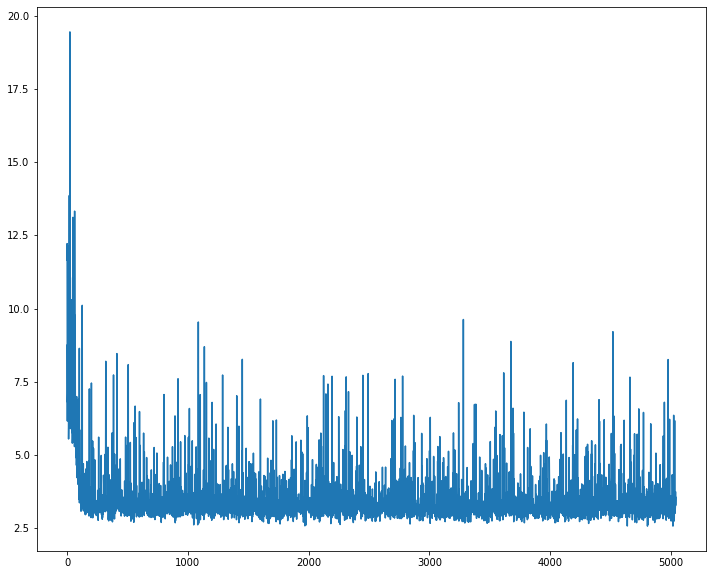

In [7]:
import matplotlib.pyplot as plt

losses_list = [t.detach().numpy() if type(t) is torch.Tensor else t for t in running_loss ]
plt.figure(figsize=(12, 10))
plt.plot(losses_list)
plt.show()

5040


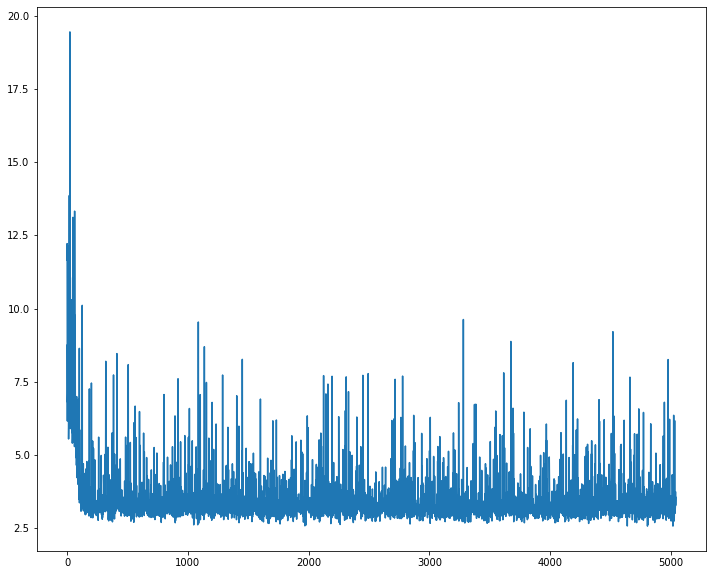

In [8]:
import matplotlib.pyplot as plt

wtout_zeros = np.array([t.detach().numpy() if type(t) is torch.Tensor else t for t in running_loss])
print(len(running_loss))
wtout_zeros = wtout_zeros[wtout_zeros != 0]
plt.figure(figsize=(12, 10))
plt.plot(wtout_zeros)
plt.show()

In [ ]:
"""
import os
PATH = os.path.join(DATA_DIR, "model_1.pt")
model = con()
model.load_state_dict(torch.load(PATH))
"""

In [18]:
model.eval()
ds = CommonVoiceUkr(TRAIN_PATH, TRAIN_SPEC_PATH)
train_dataloader = DataLoader(ds, shuffle=True, batch_size=1)

with torch.no_grad():
    X, tgt = next(iter(train_dataloader))
    print(tgt)
    print(X.shape)
    tgt = ("",)
    
    one_hots = ukr_lang_chars_handle.sentences_to_one_hots(tgt, 152)
    print(one_hots.shape)
    b, c, l, d = one_hots.shape
    
    out_data = model(X, one_hots)
    print(out_data.shape)
    result = ukr_lang_chars_handle.one_hots_to_sentence(out_data)
    print(f"result : '{result}'")

('Князь Великий в Руській землі',)
torch.Size([1, 1, 256, 1024])
torch.Size([1, 1, 38, 152])
torch.Size([1, 1, 256, 38])
result : '<blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><

In [ ]:
N = 67

print(N - N%4)

In [10]:
import os
PATH = os.path.join(DATA_DIR, "model_1.pt")
print(PATH)
torch.save(model.state_dict(), PATH)

D:\ML\Speech recognition\NLP_diploma\uk\model_1.pt
